In [1]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

In [4]:
print(len(X_train_cls))

75000


In [5]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [6]:
from xgboost import XGBClassifier
from  sklearn.ensemble import RandomForestClassifier

#model = XGBClassifier(n_jobs=-1,verbosity=2)

# cross_val_score(model, X_train_cls, y_train, cv=10)
# print(cross_val_score)

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
#model.fit(X_train_cls,y_train,verbose=True,eval_set=[(X_val_cls,y_val)])

In [8]:
model1 = RandomForestClassifier(random_state=0)

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_split': range(5, 30, 5), 
              'max_depth': range(1, 20, 2),
             # 'criterion':['gini','entropy'],
             
              # 'max_features':['auto','log2','None'],
               #'presort':['False','True']
             }

In [10]:
model1.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [11]:
gs_clf = GridSearchCV(model1,parameters, cv=5, n_jobs=-1, verbose=1)

In [12]:
model = gs_clf.fit(X_train_cls, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.3min finished


In [13]:
model.best_score_

0.6326266666666667

In [14]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 7, 'min_samples_split': 10}
max_depth: 7
min_samples_split: 10


In [15]:
pickle.dump(model,open("RF_"+str(trainSamples)+"_.pkl",'wb'))

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
# preds_val = model.predict(X_val_cls)

In [19]:
# accuracy = accuracy_score(y_val, preds_val)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [20]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [21]:
preds_test = model.predict(X_test_cls)
accuracy = accuracy_score(y_test, preds_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.58%


In [22]:
X_test_cls[0].shape[0]

768

In [23]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

In [24]:
valAccuracy = []
testAccuracy = []
mrrScore = []
from sklearn.metrics import accuracy_score
import time
# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = RandomForestClassifier(min_samples_split=model.best_params_['min_samples_split'],
                                       max_depth=model.best_params_['max_depth'],
                                       #criterion=model.best_params_['criterion'],
                                    )

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = (X_train_cls[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = (X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = (X_test_cls)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    mrr = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)

SampleSize: 100
Train Time:0.03 sec
Validation Accuracy: 50.86%
Validation Time:0.07 sec
Test Accuracy: 51.47%
Test Time:0.04 sec
MRR: (0.4254884559884557, 0.16266666666666665, 0.52)
MRR Time:0.32 sec
SampleSize: 500
Train Time:0.05 sec
Validation Accuracy: 50.53%
Validation Time:0.05 sec
Test Accuracy: 51.05%
Test Time:0.05 sec
MRR: (0.4412291486291489, 0.19933333333333333, 0.556)
MRR Time:0.29 sec
SampleSize: 1000
Train Time:0.08 sec
Validation Accuracy: 50.97%
Validation Time:0.04 sec
Test Accuracy: 51.09%
Test Time:0.04 sec
MRR: (0.44806031746031777, 0.214, 0.5366666666666666)
MRR Time:0.26 sec
SampleSize: 10000
Train Time:1.00 sec
Validation Accuracy: 55.16%
Validation Time:0.07 sec
Test Accuracy: 54.19%
Test Time:0.06 sec
MRR: (0.4857904761904773, 0.23933333333333334, 0.6313333333333333)
MRR Time:0.27 sec
SampleSize: 20000
Train Time:2.81 sec
Validation Accuracy: 58.29%
Validation Time:0.05 sec
Test Accuracy: 59.54%
Test Time:0.05 sec
MRR: (0.5164238095238113, 0.2806666666666667,

In [25]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("RF_Accuracy.png")
    #plt.show()

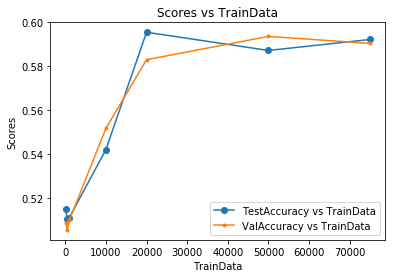

In [26]:
accuracyVisualization()

In [27]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("RF_Mrr.png")
    plt.show()

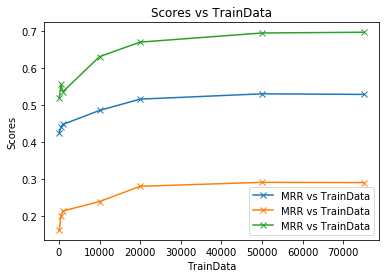

In [28]:
mrrVisualization()

In [29]:
preds_test_probs = model.predict_proba(X_test_cls)

In [30]:
qid2c,qid2indexmap = load_ranking("test")

In [31]:
mrrwrapper(qid2c,qid2indexmap,preds_test_probs)

(0.5250222222222243, 0.284, 0.6913333333333334)

In [32]:
preds_test_probs

array([[0.58452434, 0.41547566],
       [0.65606026, 0.34393974],
       [0.54782169, 0.45217831],
       ...,
       [0.51820918, 0.48179082],
       [0.51820918, 0.48179082],
       [0.51820918, 0.48179082]])